# Lemon Quality Detection

In [1]:
#!pip install tensorflow

In [2]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [3]:
#import Libraries

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
image_size = 300
batch_size = 32

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    seed = 123,
    shuffle = True,
    batch_size = batch_size,
    image_size = (image_size, image_size)    
)

Found 2528 files belonging to 3 classes.


In [6]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
class_names = dataset.class_names

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    #print(label_batch.numpy())
    print(label_batch)

(32, 300, 300, 3)
tf.Tensor([0 0 2 2 2 1 0 2 1 0 2 2 2 0 2 2 2 2 0 2 0 1 2 2 2 1 2 2 2 2 0 2], shape=(32,), dtype=int32)


In [9]:
len(dataset)

79

In [10]:
79*32

2528

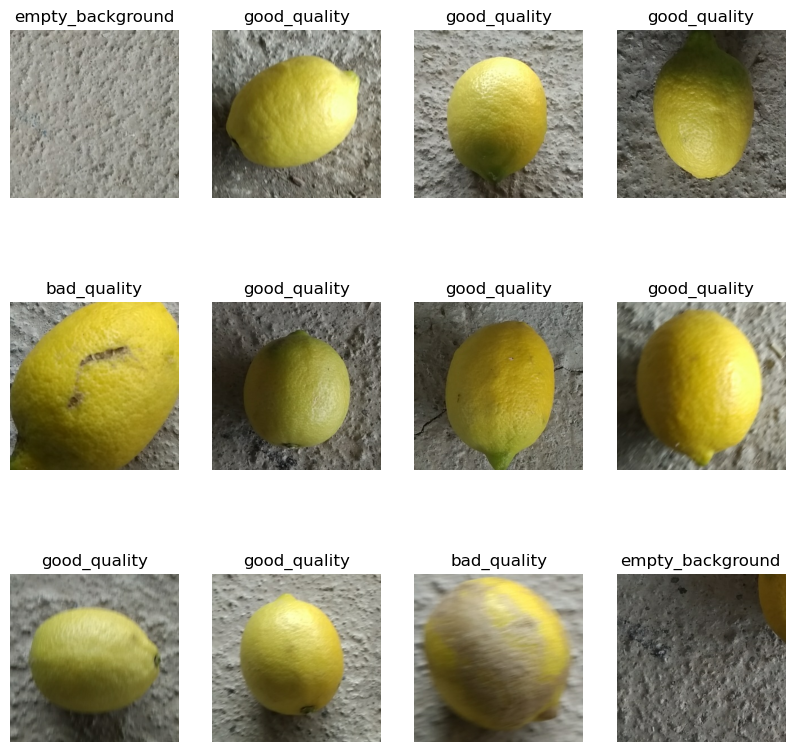

In [11]:
plt.figure(figsize = (10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")                   

In [12]:
# Dataset prepare for train, test and validations split

def split_dataset(dataset, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split+test_split+val_split) == 1
    
    ds_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
        
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds    

In [13]:
train_ds, test_ds, val_ds = split_dataset(dataset)

In [14]:
len(test_ds)

9

In [15]:
len(train_ds)

63

In [16]:
len(val_ds)

7

In [17]:
# cache, shuffle, prefetch the dataset

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [18]:
# model bulding

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1./299)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
# apply data augmentation the train_ds

train_ds = train_ds.map(
    
    lambda x, y : (data_augmentation(x, training=True), y)

).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
# model architecture

channel = 3
n_classes = 3

In [22]:
input_shape = (batch_size, image_size, image_size, channel)

model = models.Sequential([
    resize_and_rescale, 
    
    layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="relu"),
])

In [23]:
model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 300, 300, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 298, 298, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 149, 149, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 147, 147, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 73, 73, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 71, 71, 64)         

In [25]:
# compile our model

model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

In [26]:
history = model.fit(
    train_ds,
    batch_size = batch_size,
    validation_data = val_ds,
    verbose = 1,
    epochs = 30
)

Epoch 1/30
63/63 [==============================] - 391s 6s/step - loss: 1.1869 - accuracy: 0.3750 - val_loss: 1.0986 - val_accuracy: 0.3393
Epoch 2/30
63/63 [==============================] - 375s 6s/step - loss: 1.0986 - accuracy: 0.3750 - val_loss: 1.0986 - val_accuracy: 0.3393
Epoch 3/30
63/63 [==============================] - 324s 5s/step - loss: 1.0986 - accuracy: 0.3750 - val_loss: 1.0986 - val_accuracy: 0.3393
Epoch 4/30
63/63 [==============================] - 358s 6s/step - loss: 1.0986 - accuracy: 0.3750 - val_loss: 1.0986 - val_accuracy: 0.3393
Epoch 5/30
63/63 [==============================] - 365s 6s/step - loss: 1.0986 - accuracy: 0.3750 - val_loss: 1.0986 - val_accuracy: 0.3393
Epoch 6/30
63/63 [==============================] - 364s 6s/step - loss: 1.0986 - accuracy: 0.3750 - val_loss: 1.0986 - val_accuracy: 0.3393
Epoch 7/30
63/63 [==============================] - 384s 6s/step - loss: 1.0986 - accuracy: 0.3750 - val_loss: 1.0986 - val_accuracy: 0.3393
Epoch 8/30
63

In [27]:
scores = model.evaluate(test_ds)
scores

9/9 [==============================] - 26s 1s/step - loss: 1.0986 - accuracy: 0.3681


[1.0986123085021973, 0.3680555522441864]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 63}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

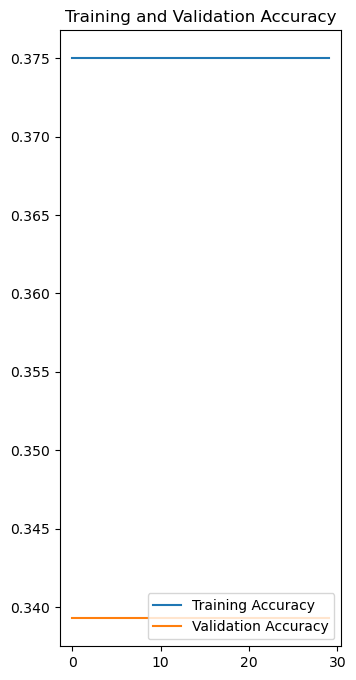

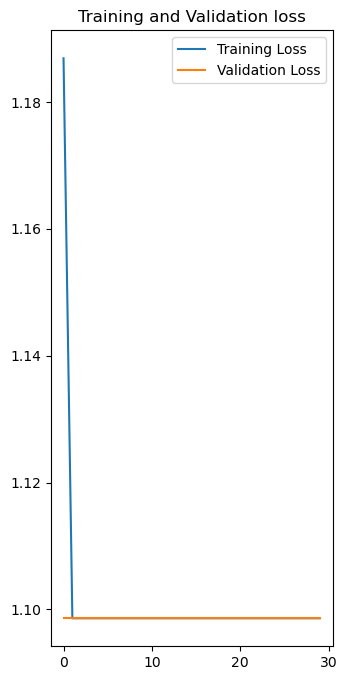

In [ ]:
epochs = 30

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label="Training Accuracy")
plt.plot(range(epochs), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label="Training Loss")
plt.plot(range(epochs), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")
plt.show()

First image to predict
Actual Label bad_quality
1/1 [==============================] - 15s 15s/step
Predicted Label bad_quality


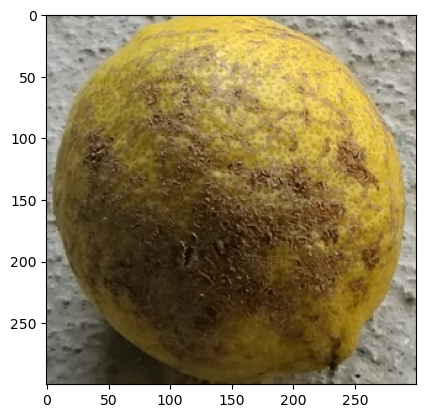

In [ ]:
# prediction

import numpy as np

for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label", class_names[np.argmax(batch_prediction[0])])

In [ ]:
# save model

model.save("lemon_model.h5")

C:\Users\mdana\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
